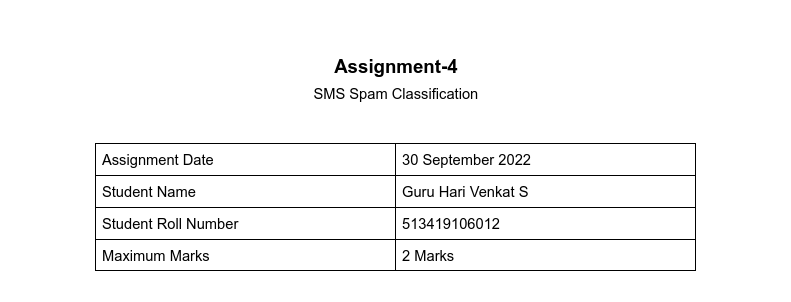

# SMS SPAM Classification

## Import required libraries


In [ ]:
import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

## Download the dataset

In [ ]:
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')
df.shape

(5572, 5)

## Read dataset and do pre-processing

In [ ]:
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.isnull().any()

v1            False
v2            False
Unnamed: 2     True
Unnamed: 3     True
Unnamed: 4     True
dtype: bool

In [ ]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [ ]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
df.columns = ["Spam/Ham","Message"]

In [ ]:
df.head()

,Spam/Ham,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


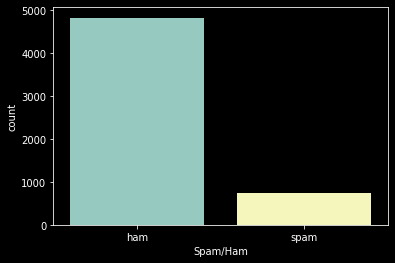

In [ ]:
sns.countplot(df["Spam/Ham"])

In [ ]:
def preprocessing(data):
      sms = contractions.fix(data)
      sms = sms.lower()
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip()
      sms = re.sub("[^a-z ]", "", sms)
      return sms
X = df["Message"].apply(preprocessing)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["Spam/Ham"])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
text_to_sequence = tokenizer.texts_to_sequences(X)

In [ ]:
max_length_sequence = max([len(i) for i in text_to_sequence])
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence

array([[   0,    0,    0, ...,   50, 3915,  134],
       [   0,    0,    0, ...,  419,    1, 1715],
       [   0,    0,    0, ..., 2653,  348, 2654],
       ...,
       [   0,    0,    0, ..., 8472,  222, 8473],
       [   0,    0,    0, ...,  144,   17,   45],
       [   0,    0,    0, ...,    3,   61,  233]], dtype=int32)

## Create Model

### Add Layers (LSTM, Dense-(Hidden Layers), Output)

In [ ]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()

## Compile the Model

In [ ]:
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 172, 32)           271200    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 326,441
Trainable params: 326,441
Non-trai

## Fit the Model

In [ ]:
lstm_model.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.2, batch_size=16)

Epoch 1/5
279/279 [==============================] - 34s 112ms/step - loss: 0.2117 - accuracy: 0.9361 - val_loss: 0.0662 - val_accuracy: 0.9821
Epoch 2/5
279/279 [==============================] - 34s 122ms/step - loss: 0.1441 - accuracy: 0.9746 - val_loss: 0.0819 - val_accuracy: 0.9830
Epoch 3/5
279/279 [==============================] - 32s 114ms/step - loss: 0.0272 - accuracy: 0.9953 - val_loss: 0.0638 - val_accuracy: 0.9848
Epoch 4/5
279/279 [==============================] - 31s 111ms/step - loss: 0.0135 - accuracy: 0.9980 - val_loss: 0.0622 - val_accuracy: 0.9865
Epoch 5/5
279/279 [==============================] - 31s 111ms/step - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.0684 - val_accuracy: 0.9839


## Save The Model

In [ ]:
lstm_model.save('sms.h5')

## Test The Model

In [ ]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_length_sequence,
                      padding = 'pre')
    return (lstm_model.predict(padded))

In [ ]:
message = str(input('Enter your message: '))
pred = predict_spam(message)
print(f"Prediction: {pred[0][0]}\n")
print(f"The sms is a {'spam' if pred[0][0]<0.5 else 'ham'}")

Enter your message: you've won something, the IRS is trying to contact you, you have a refund coming or asking you to verify your bank account
4/4 [==============================] - 0s 36ms/step
Prediction: 0.005271350499242544

The sms is a spam
